# Przykładowe wykorzystanie syjamskich sieci neuronowych 

Poniższa analiza została wykonana na potrzeby pracy magisterskiej. Przykładowe działanie syjamskich sieci neuronowych zostało przedstawione na podstawie datasetu Fashion mnist: https://github.com/zalandoresearch/fashion-mnist. Analiza zawiera:
* wczytanie pakietów oraz datasetu umożliwiających stworzenie syjamskich sieci neuronowych,
* wizualizację przykładowych obrazów ze zbioru, zdefiniowanie niezbędnych funkcji,
* trening modelu oraz obliczenie skuteczności predykcji,
* przykładowe działanie sieci.

## Wczytanie pakietów

Poniższy kod wczytuje niezbędne pakiety do wykonania kodu, m.in. pakiet tensorflow oraz keras.

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from matplotlib import pyplot

import pandas as pd
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
from numpy.random import RandomState

import random
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Flatten, Dense, Dropout,Flatten, Lambda
from tensorflow.python.keras.layers import Conv2D, Activation,AveragePooling2D,MaxPooling2D
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import load_model

from tensorflow.python.keras.datasets import fashion_mnist

random.seed(12345)

from IPython.display import Image
from IPython.core.display import HTML 

Instructions for updating:
non-resource variables are not supported in the long term


## Wczytanie data setu, reshape i normalizacja obrazków

Poniższy kod pozwala na wczytanie datasetu fashion mnist, który jest dostępny do pobrania z biblioteki keras. Poniższy kod zmienia również shape danych.

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

input_shape=(28, 28, 1)

num_classes= len(pd.unique(y_train))
epochs=20


x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Przekonwertowanie obrazu do postaci (28,28, 1) 
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Wizualizacja obrazków

Train: X=(60000, 28, 28, 1), y=(60000,)
Test: X=(10000, 28, 28, 1), y=(10000,)


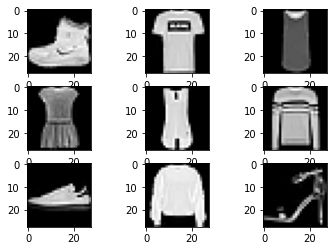

In [4]:
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# plot first few images
for i in range(9):
     # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

Zbiór danych zawiera obserwacje, które możemy zaklasyfikować do następujących klas:
* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot

Zbiór danych zawiera 70tys obserwacji, z czego 60tys obserwacji przypisano do zbioru treningowego,
a 10tys obserwacji do zbioru testowego. Każde zdjęcie jest wymiaru 28x28 pikseli. Każdy piksel
oznacza pewną wartość określającą jasność – od 0 do 255. Przykładowo 0 oznacza kolor czarny, a 255
kolor biały. Im niższa wartość tym ciemniejszy jest piksel. 

## Zdefiniowanie odległości euklidesowej

Poniższy kod definiuje funkcję liczącą odległość euklidesową pomiędzy outputami z siotrzanych sieci.

In [5]:
Image(url= "https://miro.medium.com/max/1736/1*9LeaMTcOXxeTPN-VCbKloQ.png", width=500, height=500)

In [6]:
def euclid_dis(vects):
  x,y = vects
  #suma kwadratow odleglosci miedzy wspolrzednymi  
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  #pierwiastek  
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

#wymiary 
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

## Zdefiniowanie funkcji straty

Poniższy kod definiuję funkcję straty, na podstawie której uczona będzie sieć syjamska.

In [7]:
Image(url= "https://929687.smushcdn.com/2407837/wp-content/uploads/2021/01/contrastive_loss_keras_constrastive_loss_function_updated.png?lossy=1&strip=1&webp=0", width=500, height=500)

In [8]:
#funkcja do minimalizacji w sieci - przyjmuje wartosc 0 jesli siec prawidlowo okreslila parę czy para 
#obrazkow nalezy do tej samej klasy
#porownujemy pary obrazow, y_pred to distance pomiedzy obrazkami
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

## Zdefiniowanie funkcji do tworzenia par oraz generowanie par

Poniższy kod definiuje funkcję, która pozwala na wygenerowanie par do uczenia sieci oraz generuje pary obrazków wraz z ich etykietą.

In [9]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
tr_pairs, tr_y = make_pairs(x_train, y_train)

# make test pairs
te_pairs, te_y = make_pairs(x_test, y_test)

## Zdefiniowanie architektury sieci 

Poniższy kod definiuje funkcję, która określa architekturę pojedynczej sieci.

In [10]:
def create_base_net(input_shape):
  
  input = Input(shape = input_shape)
  x = Conv2D(32, (3,3), activation = 'relu')(input)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Conv2D(64, (3,3), activation = 'tanh')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  x = Flatten()(x)
  x = Dense(128, activation = 'tanh')(x)
  x = Dropout(0.5)(x)
  x = Dense(64,activation = 'tanh')(x)
  x = Dropout(0.5)(x)
  x = Dense(10,activation = 'tanh')(x)
  model = Model(input, x)
  model.summary()
  
  return model

## Zdefiniowanie funkcji liczącej trafność predykcji

Poniższy kod definiuje funkcję do liczenia predykcji sieci syjamskich.

In [11]:
def compute_accuracy(y_true, y_pred):
    #Compute classification accuracy with a fixed threshold on distances.
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    #Compute classification accuracy with a fixed threshold on distances.
    
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

Zbiór treningowy zawiera 60tys, a zbiór testowy 10tys obrazków. Każdy obrazek ma wymiar 28x28 pikseli.

## Kompliacja sieci

Poniższy kod pozwala na kompliację/wczytanie wag sieci syjamskich.

In [12]:
# network definition
base_network = create_base_net(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclid_dis,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.load_weights('weights.h5')

#model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
#         batch_size=128,
#          epochs=epochs,
#          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)             

## Zapisanie wag modelu

In [35]:
#model.save('model.h5')
#model.save_weights("weights.h5")

## Wyliczenie trafności predykcji

Poniższy kod pozwala na wyliczenie accuracy dla sieci syjamskich na zbiorze treningowym oraz testowym. 

In [13]:
# compute final accuracy on training and test sets
y_pred_train = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred_train)
y_pred_test = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred_test)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
* Accuracy on training set: 92.83%
* Accuracy on test set: 90.52%


Accuracy oznacza procent poprawnych predykcji podobieństwa - czy dwie pary należą do tej samej klasy?

Dla około 93% par ze zbioru treningowego sieć poprawnie określiła podobieństwo, natomiast dla par ze zbioru testowego accuracy wyniosło około 90,5%.

## Przykładowe działanie sieci

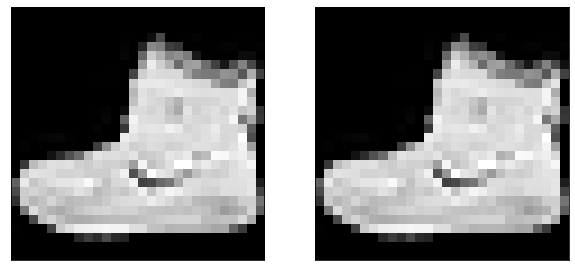

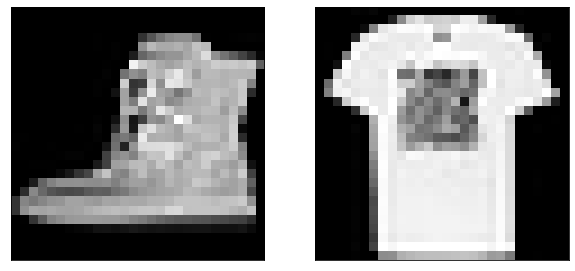


1 para : odleglosc euklidesowa =  [0.09331116]
2 para : odleglosc euklidesowa =  [2.048063]


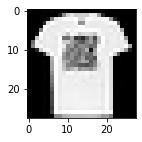

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
number_of_items = 2
import tensorflow as tf

im = tf.keras.preprocessing.image.array_to_img(
    tr_pairs[1,0],
    data_format=None,
    scale=True,
    dtype=None
)

plt.figure(figsize=(10, 5))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( tr_pairs[item,0], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(10, 5))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img(tr_pairs[item,1], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

print('')
for i in range(number_of_items):
  print(i+1, "para", ":", "odleglosc euklidesowa = ", y_pred_train[i])
plt.figure(figsize=(20, 2))
plt.imshow(im, cmap="gray")
plt.show()

Model pozwala na określenie odległości euklidesowej pomiędzy wygenerowanymi featurami obrazków. Pierwsza para zawiera dwa obrazki butów, w tym przypadku odległośc jest niewielka. Gdy porównujemy buta z koszulką, odległość istotnie wzrasta. 

<div style="text-align: right"> Kacper Kalinowski </div>
<div style="text-align: right"> wrzesień 2021 </div>